In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
from pytrends.request import TrendReq
from scipy.optimize import minimize
import copy
import time

import pickle

In [8]:
sns.set(color_codes=True)
tips = sns.load_dataset("tips")

In [9]:
pops = {"IT-65":1311580,
"IT-77":562869,
"IT-78":1947131,
"IT-72":5801692,
"IT-45":4459477,
"IT-36":1215220,
"IT-62":5879082,
"IT-42":1550640,
"IT-25":10060574,
"IT-57":1525271,
"IT-67":305617,
"IT-21":4356406,
"IT-75":4029053,
"IT-88":1639591,
"IT-82":4999891,
"IT-52":3729641,
"IT-32":1072276,
"IT-55":882015,
"IT-23":125666,
"IT-34":4905854
       }


codes = {"IT-65":"Abruzzo",
"IT-77":"Basilicata",
"IT-78":"Calabria",
"IT-72":"Campania",
"IT-45":"Emilia-Romagna",
"IT-62":"Lazio",
"IT-42":"Liguria",
"IT-25":"Lombardia",
"IT-57":"Marche",
"IT-67":"Molise",
"IT-21":"Piemonte",
"IT-75":"Puglia",
"IT-52":"Toscana",
"IT-55":"Umbria",
"IT-34":"Veneto",
"IT-36":"Friuli-Venezia Giulia",
"IT-88":"Sardegna",
"IT-82":"Sicilia",
"IT-32":"Trentino-Alto Adige",
"IT-23":"Valle d'Aosta"}

#codes = {"IT-25":"Italia"}

inv_codes = {v: k for k, v in codes.items()}

#kw_list =['coronavirus', 'covid', 'corona','virus']
kw_list =['coronavirus']
today = str(date.today())
#, "2020-02-10", "2020-02-21"
milestones = ["2020-01-15", "2020-01-24","2020-02-10", today]
#timeframes = [ "2020-01-15 2020-01-23", "2020-01-23 2020-02-20", "2020-02-20 2020-02-21", "2020-02-21 "+today ]

# Population based normalization

In [287]:
pytrend = TrendReq(timeout=(10,100),retries=10)

raw_data_pop_w = {}
it_raw_data_pop_w = {}

print("POPW")

for i in range(1,len(milestones)):
    timeframe = milestones[i-1] + " " + milestones[i]
    print(timeframe)
    c = "IT"
    pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
    if i == 1:
        it_raw_data_pop_w = pytrend.interest_over_time().drop("isPartial", axis=1)
        it_raw_data_pop_w *= sum(pops.values())
    else:
        tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
        tmp *= sum(pops.values())
        tmp *= it_raw_data_pop_w[kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
        it_raw_data_pop_w = it_raw_data_pop_w.append(tmp[1:])
    for c in codes:
        print("\t",codes[c]) 
        pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
        if i == 1:
            raw_data_pop_w[c] = pytrend.interest_over_time().drop("isPartial", axis=1)
            raw_data_pop_w[c][kw_list[0]] *= pops[c]
        else:
            tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
            tmp *= pops[c]
            tmp *= raw_data_pop_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
            raw_data_pop_w[c] = raw_data_pop_w[c].append(tmp[1:])


POPW
2020-01-15 2020-01-24
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige
	 Valle d'Aosta
2020-01-24 2020-02-10
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige
	 Valle d'Aosta
2020-02-10 2020-04-09
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige
	 Valle d'Aosta


# Interest by Region based normalization

In [26]:
pytrend = TrendReq(timeout=(10,100),retries=10)

raw_data_ibr_w = {}
it_raw_data_ibr_w = {}

print("IBRW")

for i in range(1,len(milestones)):
    timeframe = milestones[i-1] + " " + milestones[i]
    print(timeframe)
    c = "IT"
    pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
    dfr = pytrend.interest_by_region(inc_low_vol=True, inc_geo_code=True)
    if i == 1:
        it_raw_data_ibr_w = pytrend.interest_over_time().drop("isPartial", axis=1)
        it_raw_data_ibr_w *= dfr[kw_list[0]].sum()
    else:
        tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
        tmp *= dfr[kw_list[0]].sum()
        tmp *= it_raw_data_ibr_w[kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
        it_raw_data_ibr_w = it_raw_data_ibr_w.append(tmp[1:])
    for c in codes:
        print("\t",codes[c]) 
        pytrend.build_payload(kw_list,geo=c,timeframe=timeframe)
        if i == 1:
            raw_data_ibr_w[c] = pytrend.interest_over_time().drop("isPartial", axis=1)
            raw_data_ibr_w[c][kw_list[0]] *= float(dfr[dfr["geoCode"] == c][kw_list[0]])
        else:
            tmp = pytrend.interest_over_time().drop("isPartial", axis=1)
            tmp *= float(dfr[dfr["geoCode"] == c][kw_list[0]])
            tmp *= raw_data_ibr_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0]
            raw_data_ibr_w[c] = raw_data_ibr_w[c].append(tmp[1:])
            
           # print(raw_data_ibr_w[c][kw_list[0]].iloc[-1]/tmp[kw_list[0]].iloc[0])




IBRW
2020-01-15 2020-01-24
	 Abruzzo
	 Basilicata
	 Calabria
	 Campania
	 Emilia-Romagna
	 Lazio
	 Liguria
	 Lombardia
	 Marche
	 Molise
	 Piemonte
	 Puglia
	 Toscana
	 Umbria
	 Veneto
	 Friuli-Venezia Giulia
	 Sardegna
	 Sicilia
	 Trentino-Alto Adige
	 Valle d'Aosta
2020-01-24 2020-02-10
	 Abruzzo
1.6
	 Basilicata
9.333333333333332
	 Calabria
2.3333333333333335
	 Campania
3.285714285714285
	 Emilia-Romagna
1.909090909090909
	 Lazio
2.2857142857142856
	 Liguria
2.5
	 Lombardia
2.2222222222222223
	 Marche
2.083333333333333
	 Molise
2.4285714285714284
	 Piemonte
2.2
	 Puglia
1.4285714285714284
	 Toscana
3.2857142857142856
	 Umbria
2.0909090909090913
	 Veneto
2.625
	 Friuli-Venezia Giulia
2.3636363636363638
	 Sardegna
2.625
	 Sicilia
1.857142857142857
	 Trentino-Alto Adige
2.5882352941176467
	 Valle d'Aosta
1.7692307692307692
2020-02-10 2020-04-14
	 Abruzzo
7.0
	 Basilicata
5.5
	 Calabria
8.2
	 Campania
4.142857142857142
	 Emilia-Romagna
7.666666666666666
	 Lazio
5.0
	 Liguria
5.8
	 Lomba

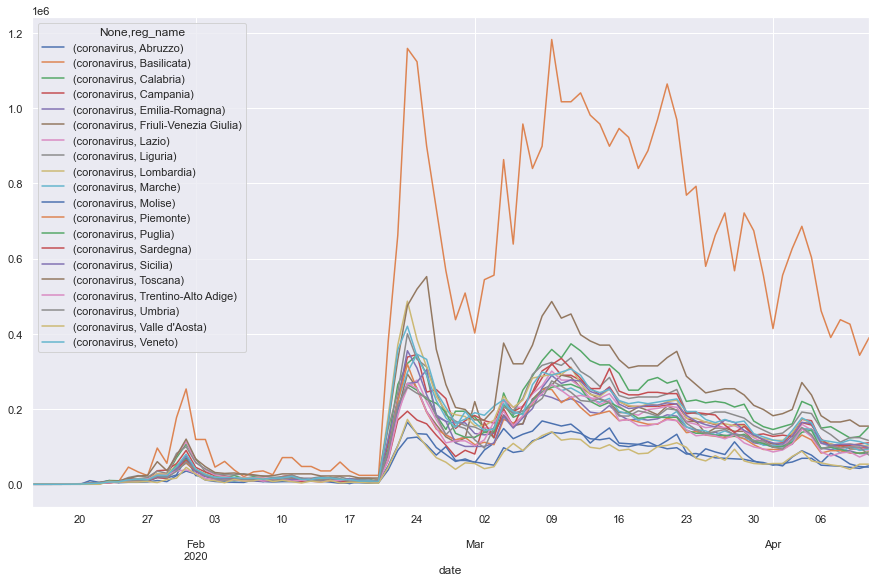

In [24]:
def transform_to_df(j_dict):
    df = pd.concat(j_dict.values(), keys=j_dict.keys())
    df.index.names = ["region", "date"]
    df=df.reset_index()
    df['reg_name']=[codes[r["region"]] for i,r in df.iterrows()]
    df_log = df.replace(0, 1)
    df["coronavirus_log"] = np.log10(df_log["coronavirus"])
    return df
df = transform_to_df(raw_data_ibr_w)

piv = pd.pivot_table(df, index=['date'],columns=['reg_name'], values=['coronavirus'])
piv.plot(figsize=(15,9))

In [25]:

# with open( "it_raw_data_pop_w.p", "wb" ) as f:
#     pickle.dump( it_raw_data_pop_w, f)
# with open( "raw_data_pop_w.p", "wb" ) as f:
#     pickle.dump( raw_data_pop_w, f )
# with open( "it_raw_data_ibr_w.p", "wb" ) as f:
#     pickle.dump( it_raw_data_ibr_w, f )
# with open( "raw_data_ibr_w.p", "wb" ) as f:
#     pickle.dump( raw_data_ibr_w, f )


In [20]:
it_raw_data_pop_w.plot()
for c in raw_data_pop_w:
    print(c)
    raw_data_pop_w[c].plot()
    plt.show()

NameError: name 'it_raw_data_pop_w' is not defined

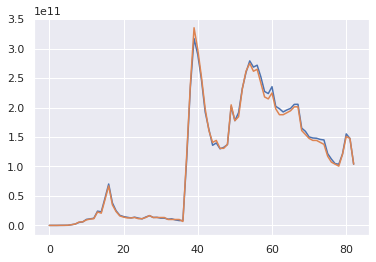

/home/pietro/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


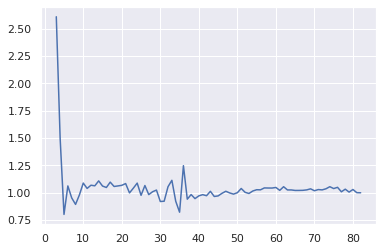

In [298]:
tmp = copy.deepcopy(raw_data_pop_w[c])
tmp["coronavirus"] = 0
for v in raw_data_pop_w.values():
    tmp["coronavirus"] += v["coronavirus"]
    
summed_pop = np.array(tmp["coronavirus"].tolist())
nation = np.array(it_raw_data_pop_w["coronavirus"].tolist())
plt.plot(summed_pop)
plt.plot(nation)
#plt.yscale("log")
plt.show()
plt.plot(summed_pop/nation)

IT-65


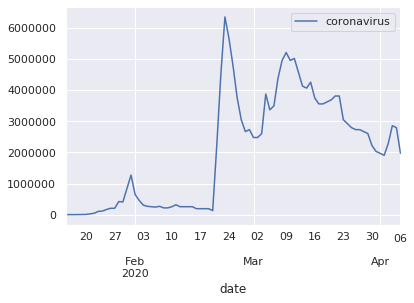

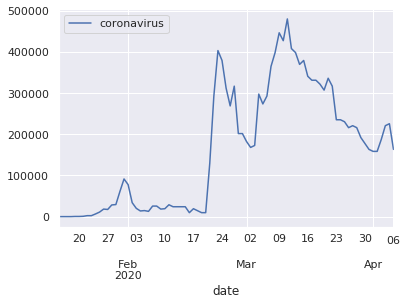

IT-77


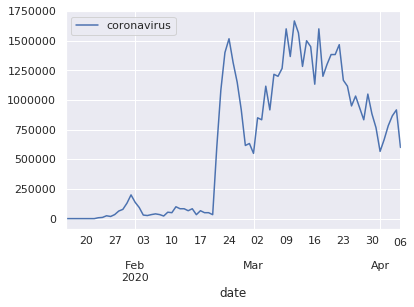

IT-78


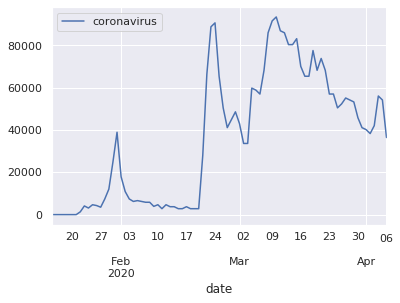

IT-72


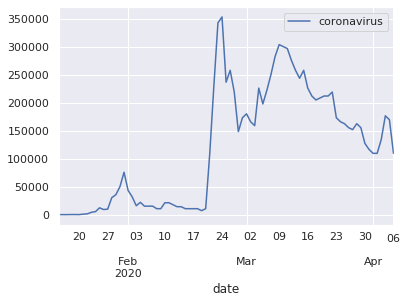

IT-45


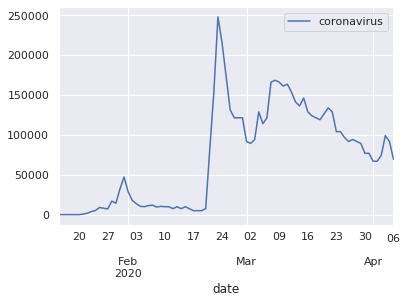

IT-62


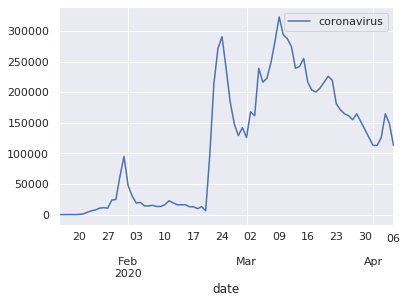

IT-42


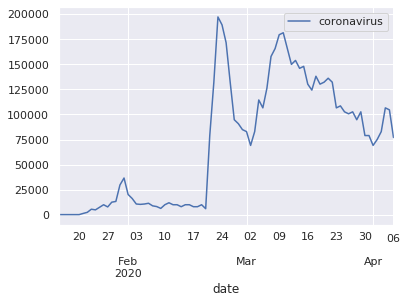

IT-25


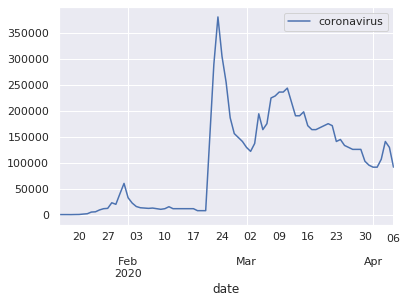

IT-57


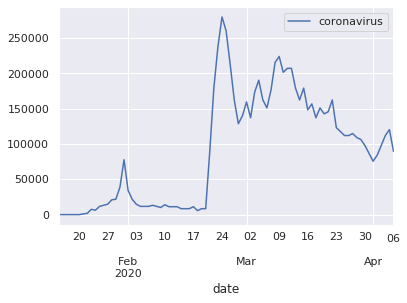

IT-67


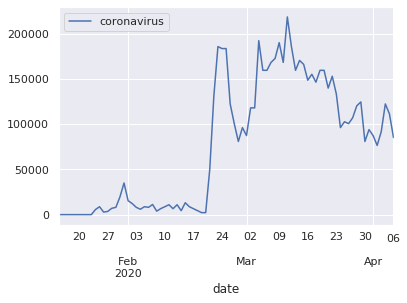

IT-21


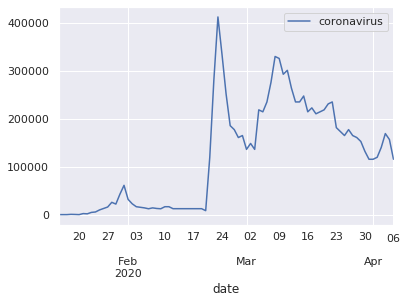

IT-75


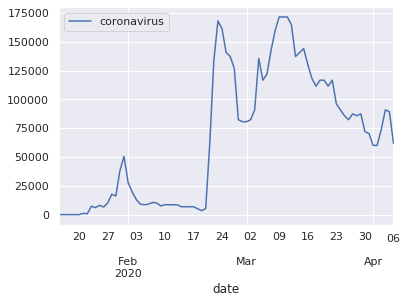

IT-52


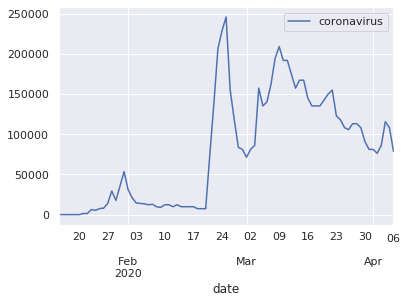

IT-55


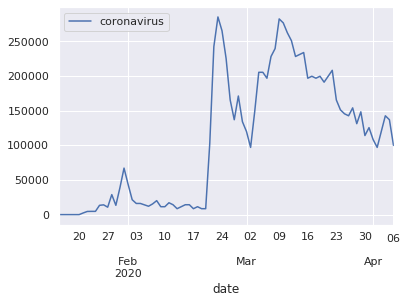

IT-34


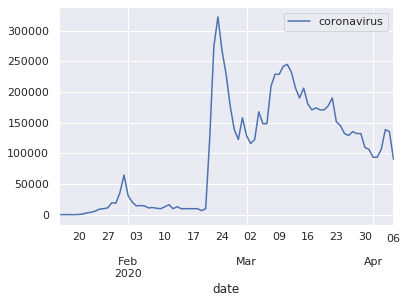

IT-36


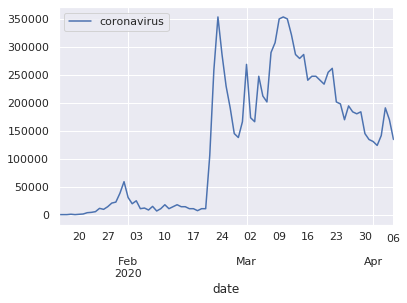

IT-88


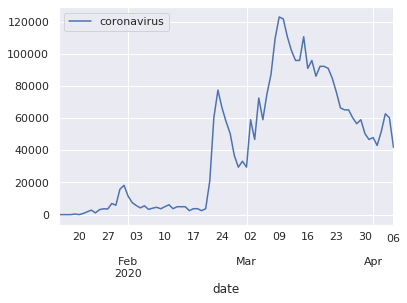

IT-82


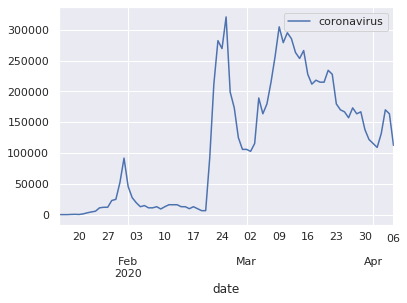

IT-32


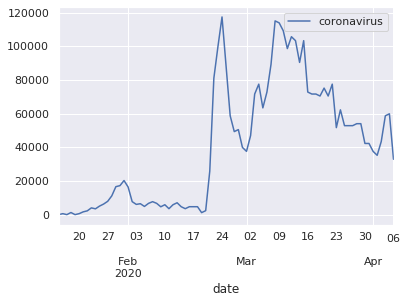

IT-23


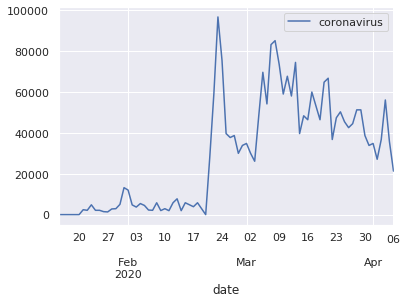

In [291]:
it_raw_data_ibr_w.plot()
for c in raw_data_ibr_w:
    print(c)
    raw_data_ibr_w[c].plot()
    plt.show()

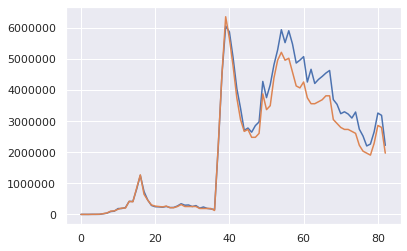

/home/pietro/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


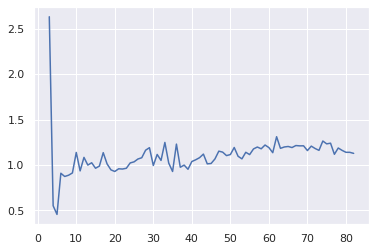

In [299]:
tmp = copy.deepcopy(raw_data_ibr_w[c])
tmp["coronavirus"] = 0
for v in raw_data_ibr_w.values():
    tmp["coronavirus"] += v["coronavirus"]

summed_ibr = np.array(tmp["coronavirus"].tolist())
nation = np.array(it_raw_data_ibr_w["coronavirus"].tolist())
plt.plot(summed_ibr)
plt.plot(nation)
#plt.yscale("log")
plt.show()
plt.plot(summed_ibr/nation)

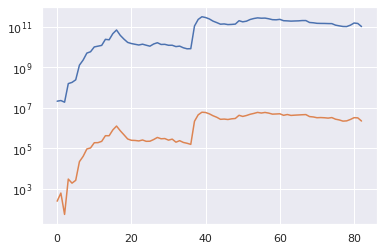

In [295]:
plt.plot(summed_pop)
plt.plot(summed_ibr)
plt.yscale("log")

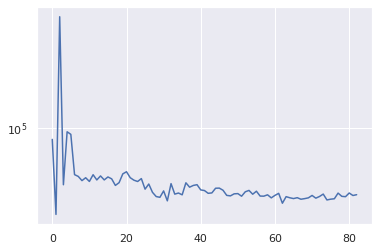

In [296]:
plt.plot(summed_pop/summed_ibr)
plt.yscale("log")

In [297]:
for i in it_raw_data_ibr_w.iterrows():
    print(str(i[0].date()),int(i[1]))

2020-01-15 0
2020-01-16 0
2020-01-17 0
2020-01-18 1145
2020-01-19 3435
2020-01-20 5725
2020-01-21 24045
2020-01-22 45800
2020-01-23 104195
2020-01-24 114500
2020-01-25 165388
2020-01-26 203555
2020-01-27 203555
2020-01-28 419833
2020-01-29 407111
2020-01-30 839666
2020-01-31 1272222
2020-02-01 648833
2020-02-02 458000
2020-02-03 305333
2020-02-04 267166
2020-02-05 254444
2020-02-06 241722
2020-02-07 267166
2020-02-08 216277
2020-02-09 216277
2020-02-10 254444
2020-02-11 318055
2020-02-12 254444
2020-02-13 254444
2020-02-14 254444
2020-02-15 254444
2020-02-16 190833
2020-02-17 190833
2020-02-18 190833
2020-02-19 190833
2020-02-20 127222
2020-02-21 2226388
2020-02-22 4516388
2020-02-23 6361111
2020-02-24 5661388
2020-02-25 4770833
2020-02-26 3753055
2020-02-27 3053333
2020-02-28 2671666
2020-02-29 2735277
2020-03-01 2480833
2020-03-02 2480833
2020-03-03 2608055
2020-03-04 3880277
2020-03-05 3371388
2020-03-06 3498611
2020-03-07 4389166
2020-03-08 4961666
2020-03-09 5216111
2020-03-10 496